In [1]:
import warnings

import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client
from pint import UnitStrippedWarning
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

warnings.simplefilter("ignore", category=UnitStrippedWarning)
xr.set_options(
    display_expand_attrs=False,
    display_expand_data_vars=False,
    display_expand_coords=False,
    display_expand_data=False,
)

In [2]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_cmems_climato.zarr"
path_to_npp = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_observed_npp_climato.zarr"
path_to_cafe = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_cafe_climato.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_obs_zoo_climato_monthly_2002_2015.zarr"
export_file_name = "SeapoPym_HOT_climato_obs_npp_opti_all_parameters_2_groups"

In [3]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-01"
TIME_END = "2008-01-01"
STABILIZATION_TIME = 12
SAVE = True

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 193kB
Dimensions:              (time: 1096, latitude: 1, longitude: 1, depth: 3)
Coordinates: (4)
Data variables: (13)
Attributes: (6)

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[114.74266258672766]] [[113.25850445781492]] [[113.67641789059907]] ... [[114.06464559061169]] [[112.96254669775898]] [[114.74266258672766]]]
Units,meter


<!-- ## Observed NPP -->


In [6]:
# observed_npp = xr.open_zarr(path_to_npp)
# observed_npp = observed_npp.sel(time=slice(TIME_START, TIME_END))
# observed_npp = observed_npp.dropna("time", how="all")
# observed_npp = observed_npp.resample(time="D").interpolate("linear")
# observed_npp.load()

In [7]:
cafe_npp = xr.open_zarr(path_to_cafe)
cafe_npp = cafe_npp.sel(time=slice(TIME_START, TIME_END))
cafe_npp = cafe_npp.dropna("time", how="all")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.load()

<xarray.Dataset> Size: 18kB
Dimensions:    (time: 1096, latitude: 1, longitude: 1)
Coordinates: (3)
Data variables: (1)

### Observations


In [8]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("depth")
observations

Magnitude,[[[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]]]
Units,milligram/meter2
Magnitude,[[[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]]]
Units,milligram/meter2


Select the kind of observation you want to use.


In [9]:
# observations_selected = observations[["day_lowess_0.2", "night_lowess_0.2"]].rename(
#     {"day_lowess_0.2": "day", "night_lowess_0.2": "night"}
# )

observations_selected = observations[["day", "night"]]

Remove the X first months to let the model reach the stationary state.


In [10]:
observations_selected_without_init = observations_selected.isel(time=slice(STABILIZATION_TIME, None))
observations_selected_without_init

Magnitude,[[[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]]]
Units,milligram/meter2
Magnitude,[[[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]]]
Units,milligram/meter2


Create structure for SeapoPym simulation.


In [11]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1 / 12, timestep=1),
    # primary_production=ForcingUnit(forcing=observed_npp["l12"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=1 / 12, timestep=1),
)

2025-05-20 15:57:02,369 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [12]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("D1N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D1N1_tr_max", 0, 100),
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 100, 200),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=1,
        night_layer=0,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("D2N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D2N1_tr_max", 0, 100),
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 100, 200),
    ),
]

In [13]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[
        Observation(name="Hot climato", observation=observations_selected_without_init, observation_type="monthly")
    ],
    normalized_mse=True,
    root_mse=True,
)

Set the genetic algorithm meta parameters.


In [14]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.30,
    INDPB=0.2,
    ETA=4,
    CXPB=0.7,
    NGEN=5,
    POP_SIZE=1000,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [15]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [16]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
    logbook_path=f"{export_file_name}_logbook.json",
)

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49435 instead
  warnings.warn(


And watch the magic on the Dask dashboard :


In [17]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:49435/status,
Dashboard: http://127.0.0.1:49435/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49436,Workers: 4
Dashboard: http://127.0.0.1:49435/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:49448,Total threads: 3
Dashboard: http://127.0.0.1:49451/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:49439,


## Run the optimization


In [18]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,-77.642589,113.035402,-767.146620,-1.104345,1000,0.000
1,-18.774962,41.974515,-825.244569,-1.104345,1000,0.224
2,-8.561213,21.115916,-250.687267,-1.053395,1000,0.192
3,-6.801037,15.053613,-260.074441,-0.978965,1000,0.207
4,-7.514948,19.645102,-283.499394,-1.006588,1000,0.195


Generations: 100%|██████████| 5/5 [04:57<00:00, 59.49s/it]


## Optimization statistics


In [19]:
viewer.hall_of_fame.head(10)

D1N1_energy_coefficient  D1N1_tr_max  D1N1_tr_rate  \
generation individual                                                       
3          711                        0.074920    32.492457     -0.005838   
4          729                        0.079311    77.722120     -0.164592   
           709                        0.110184     8.800058     -0.004956   
2          226                        0.110184     8.800058     -0.004956   
4          417                        0.079311    54.890392     -0.164592   
3          933                        0.079311    77.722120     -0.164592   
2          953                        0.031163    39.536690     -0.077380   
3          781                        0.031163    39.536690     -0.077380   
2          869                        0.111944    88.775924     -0.183140   
3          295                        0.025712    42.888567     -0.257481   

                       D1N1_inv_lambda_max  D1N1_inv_lambda_rate  \
generation individual                                              
3          711                  180.651716             -0.128933   
4          729                  150.556205             -0.124160   
           709                  173.953878             -0.147417   
2          226                  173.953878             -0.147417   
4          417                  150.556205             -0.124160   
3          933                  150.556205             -0.124160   
2          953                  122.484701             -0.082740   
3          781                  122.484701             -0.082740   
2          869                  119.006104             -0.135383   
3          295                  105.290802             -0.066117   

                       D2N1_energy_coefficient  D2N1_tr_max  D2N1_tr_rate  \
generation individual                                                       
3          711                        0.011660    70.492624     -0.233048   
4          729                        0.213500    59.666737     -0.015057   
           709                        0.173463    34.826016     -0.110403   
2          226                        0.173463    34.826016     -0.147557   
4          417                        0.231621    60.778591     -0.015057   
3          933                        0.231621    60.778591     -0.015057   
2          953                        0.153030    95.012540     -0.221356   
3          781                        0.153030    39.682339     -0.207613   
2          869                        0.178572    45.816982     -0.048981   
3          295                        0.304411    59.783278     -0.168684   

                       D2N1_inv_lambda_max  D2N1_inv_lambda_rate   fitness  
generation individual                                                       
3          711                  194.122691             -0.120454  0.978965  
4          729                  134.919916             -0.272185  1.006588  
           709                  123.088873             -0.243300  1.052565  
2          226                  155.523192             -0.264709  1.053395  
4          417                  134.919916             -0.272185  1.079124  
3          933                  134.919916             -0.272185  1.085413  
2          953                  126.725432             -0.215914  1.089300  
3          781                  126.725432             -0.215914  1.096800  
2          869                  197.240424             -0.269269  1.099424  
3          295                  120.148490             -0.261951  1.101414

In [20]:
viewer.fitness_evolution()

In [21]:
viewer.parameters_standardized_deviation()

In [22]:
viewer.parameters_scatter_matrix(nbest=10_000)

In [23]:
fig = viewer.box_plot(5, nbest=1000)
fig.show()

In [24]:
groups = [
    ["D1N1_energy_coefficient", "D1N1_tr_rate", "D1N1_tr_max", "D1N1_inv_lambda_rate", "D1N1_inv_lambda_max"],
    ["D2N1_energy_coefficient", "D2N1_tr_rate", "D2N1_tr_max", "D2N1_inv_lambda_rate", "D2N1_inv_lambda_max"],
]

fig = viewer.parallel_coordinates(nbest=2_000, unselected_opacity=0, parameter_groups=groups, uniformed=True)

for group in fig:
    display(group)

# Plots


### Time series of X best individuals


In [25]:
fig = viewer.time_series(10, title=["HOT"], client=client)[0]
fig.update_layout(width=1000, height=600)

### Correlation matrix of X best individuals


In [26]:
fig = viewer.parameters_correlation_matrix(10_000)
fig.update_layout(width=1000, height=1000)

In [27]:
import plotly.express as px
import numpy as np


def weighted_correlation_matrix(X, w):
    """
    Calcule la matrice de corrélation pondérée de Pearson pour un ensemble de variables.

    Paramètres :
    X : array-like (NxM) - Matrice des observations (N observations, M variables)
    w : array-like (N,)  - Poids associés à chaque observation

    Retourne :
    R_w : array (MxM) - Matrice de corrélation pondérée (M variables x M variables)
    """
    X = np.array(X)
    w = np.array(w).reshape(-1, 1)  # Convertir en colonne (N,1) si nécessaire

    # Nombre de variables
    M = X.shape[1]

    # Moyennes pondérées pour chaque variable
    mean_w = np.sum(w * X, axis=0) / np.sum(w)

    # Écarts-types pondérés pour chaque variable
    std_w = np.sqrt(np.sum(w * (X - mean_w) ** 2, axis=0))

    # Matrice de covariance pondérée
    cov_w = np.dot((X - mean_w).T, w * (X - mean_w))

    # Matrice de corrélation pondérée
    R_w = cov_w / np.outer(std_w, std_w)

    # Nan sur la diagonale
    np.fill_diagonal(R_w, np.nan)

    return R_w


X = viewer.hall_of_fame.to_numpy()[:, :-1]
# Solution polynomiale
# w = np.abs(1 / viewer.hall_of_fame["fitness"].to_numpy())
# Solution linéaire
w = viewer.hall_of_fame["fitness"].to_numpy()
w = (-w) + np.max(w)

R_w = weighted_correlation_matrix(X, w)

fig = px.imshow(
    R_w,
    width=800,
    height=700,
    text_auto=False,
    aspect="auto",
    color_continuous_scale=[[0, "blue"], [0.5, "white"], [1, "red"]],
    zmin=-1,
    zmax=1,
    x=viewer.hall_of_fame.columns[:-1],
    y=viewer.hall_of_fame.columns[:-1],
)
# enlève le fond et la grille
fig.update_xaxes(showgrid=False, showline=False, zeroline=False)
fig.show()

Text(0.5, 1.0, 'Poids et fitness des individus : w = -fitness + max(fitness)')

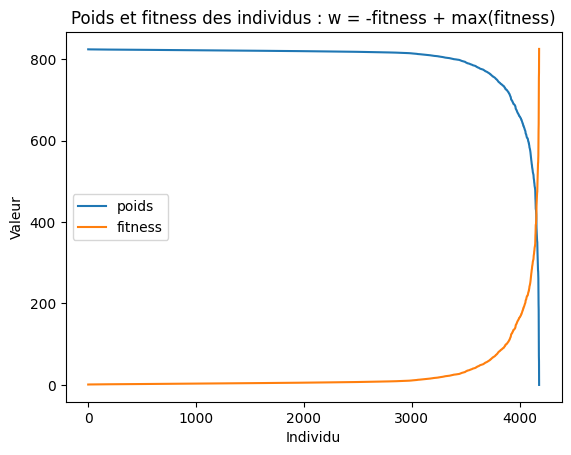

In [28]:
plt.plot(w)
plt.plot(viewer.hall_of_fame["fitness"].to_numpy())
plt.legend(["poids", "fitness"])
plt.xlabel("Individu")
plt.ylabel("Valeur")
plt.title("Poids et fitness des individus : w = -fitness + max(fitness)")

Text(0.5, 1.0, 'Poids et fitness des individus : w = absolute(1 / fitness)')

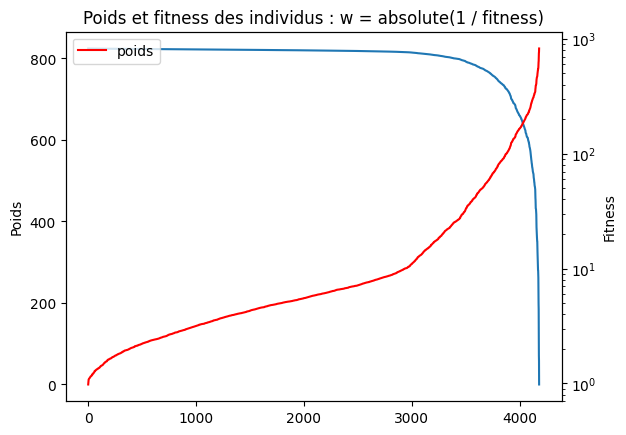

In [29]:
fig, ax = plt.subplots()
ax.plot(w)
ax2 = ax.twinx()

ax2.plot(viewer.hall_of_fame["fitness"].to_numpy(), color="red")
plt.legend(["poids", "fitness"])
plt.xlabel("Individu")
ax.set_ylabel("Poids")
ax2.set_ylabel("Fitness")
ax2.set_yscale("log")
plt.title("Poids et fitness des individus : w = absolute(1 / fitness)")

### Taylor Diagram


In [30]:
fig = viewer.taylor_diagram(50, client=client)
# dont show legend
fig.update_layout(showlegend=False)
fig.show()

# OLD


In [31]:
optimized_biomass_pandas = (
    viewer.best_simulation.pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
original_biomass_pandas = (
    viewer.original_simulation.pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
observations_day_pandas = (
    observations_selected_without_init.pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .day.dropna("time")
    .to_dataframe()
    .reset_index()
    .set_index("time")["day"]
)
observations_night_pandas = (
    observations_selected_without_init.pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .night.dropna("time")
    .to_dataframe()
    .reset_index()
    .set_index("time")["night"]
)
layer_pandas = epi_layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

Then resample to month.


In [32]:
monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred_d1n1 = optimized_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d1n1.index = monthly_pred_d1n1.index.to_period("M").to_timestamp()

monthly_pred_d2n1 = optimized_biomass_pandas.iloc[:, 1].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d2n1.index = monthly_pred_d2n1.index.to_period("M").to_timestamp()

monthly_pred_orignal = original_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_orignal.index = monthly_pred_orignal.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

correlation [0.9382005315713411, 0.9269902452626747, 0.8092735990888548, 0.8517345364755531]
norm STD [0.7037226791477716, 0.9290589243982849, 1.0833197697214083, 0.9407778943070626]
bias [0.3648777723641946, -0.19786813920115093, 1.3478615834439944, -0.7883527322507278]
NRMSE [0.4180426124648331, 0.37509114175252406, 0.6482110346608875, 0.5314856526273172]
name ['HOT Day', 'HOT Night', 'Original Day', 'Original Night']


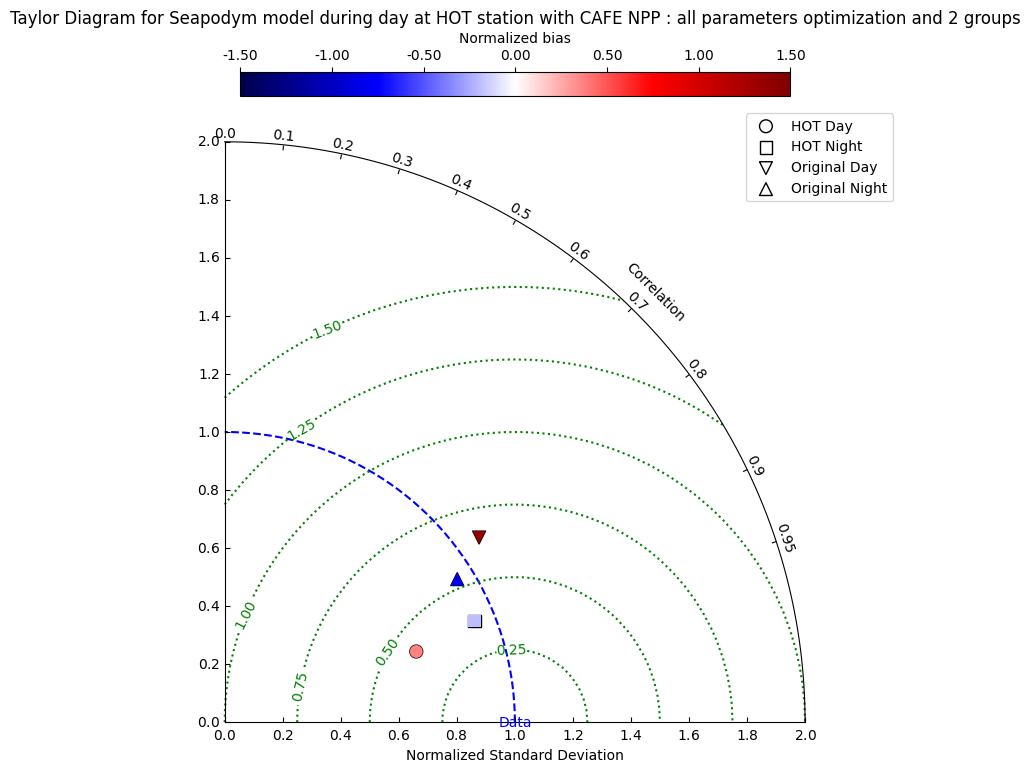

In [33]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred_d1n1, monthly_pred_d1n1 + monthly_pred_d2n1, monthly_pred_orignal, monthly_pred_orignal]
all_obs = [monthly_obs_day, monthly_obs_night, monthly_obs_day, monthly_obs_night]

all_names = ["HOT Day", "HOT Night", "Original Day", "Original Night"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title(
    "Taylor Diagram for Seapodym model during day at HOT station with CAFE NPP : all parameters optimization and 2 groups"
)

# export the figure
if SAVE:
    plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()